<a href="https://colab.research.google.com/github/pulkitkapoor15/image-description-grid-bream-search/blob/main/Image_summary_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import all the required libraries
from google.colab import drive
import pathlib
import glob
from PIL import Image
import pandas as pd
from functools import reduce
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 
import seaborn as sns
from pickle import dump,load
import time
import numpy as np

import keras
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D

from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Drive not mounted, so nothing to flush and unmount.


In [3]:

!unzip -q "/content/drive/My Drive/eye.zip"


In [4]:
#Import the dataset and read the image into a seperate variable
images='Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


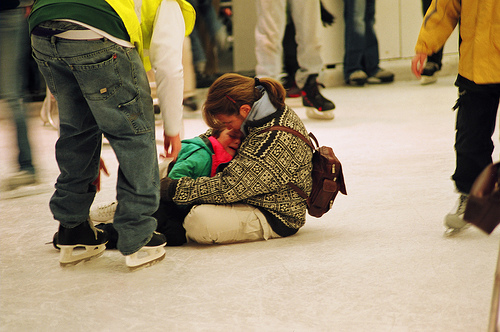

In [5]:
#Visualise both the images & text present in the dataset

Image.open(all_imgs[1])

In [6]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    text = open(filename).read()
    return text

def get_id_and_caption(txt):
  key, value, path = [], [], []
  txt = txt.splitlines()[1:]
  for sen in txt:
    idx = sen.index(",")
    id, caption = sen[:idx], sen[idx + 1:]
    key.append(id)
    value.append(caption)
    path.append(images+'/'+id)
  return key, value, path

text_file="captions.txt"
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
key, value, path = get_id_and_caption(doc)

all_img_id= key #store all the image id here
all_img_vector= path #store all the image path here
annotations= value #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


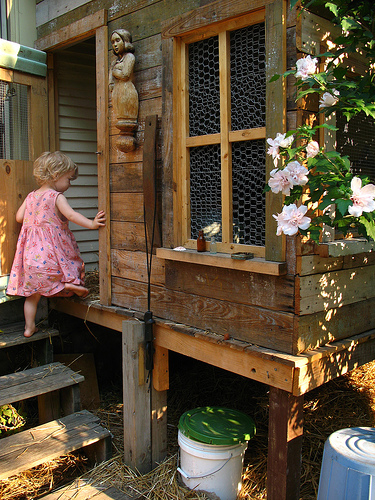

In [8]:
Image.open(all_img_vector[1])

In [9]:
#Create a list which contains all the captions
annotations = df.Captions.apply(lambda z:"<start> " + z + " <end>") #write your code here

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path = df.Path.to_list() #write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [10]:
#Create the vocabulary & the counter for the captions
def get_word_counter(data, col):
  counter = []
  for c in data[col]:
      counter += c.split(" ")
  return counter
vocabulary= get_word_counter(df, "Captions") #write your code here

val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

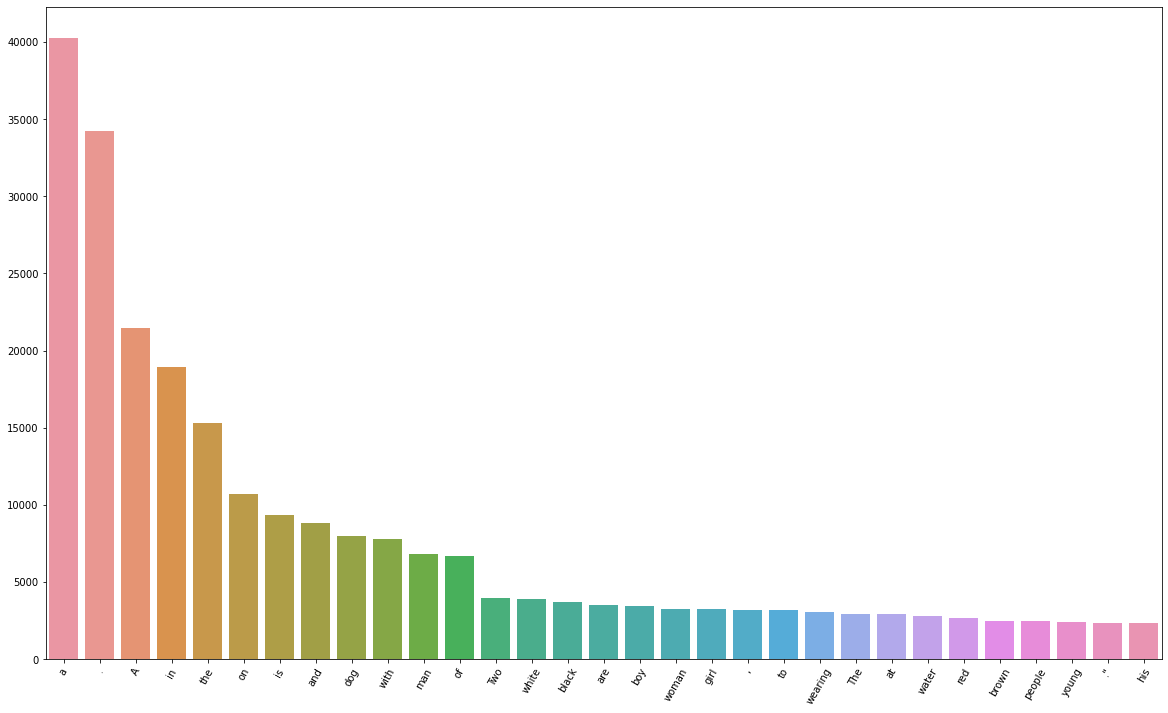

In [11]:
#Visualise the top 30 occuring words in the captions

def get_k_top_words(word_dict, k):
  k += 1
  key = list(word_dict.keys())
  value = list(word_dict.values())
  sorted_values = sorted(value, reverse=True)[:k]
  sorted_keys = []
  for i in sorted_values:
      if sorted_values.count(i) == 1:
          sorted_keys.append(key[value.index(i)])
      elif sorted_values.count(i) == 2:
          first = value.index(i)
          second = value[first + 1:].index(i)
          second += first + 1
          a, b = key[first], key[second]
          if a not in sorted_keys and b not in sorted_keys:
              sorted_keys.append(a)
              sorted_keys.append(b)
  plt.figure(figsize=(20,12))
  sns.barplot(x=sorted_keys,y=sorted_values)
  plt.xticks(rotation=60)
  plt.show()
#write your code here
get_k_top_words(val_count, 30)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [12]:
# create the tokenizer
top_word_count = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
#your code here
tokenizer.fit_on_texts(annotations)
train_text_seqs = tokenizer.texts_to_sequences(annotations)
train_text_seqs

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4],
 [3, 2, 16, 10, 9, 2, 844, 10, 18, 344, 4],
 [3, 2, 16, 10, 9, 2, 1576, 236, 10, 35, 11, 138, 83, 7, 6, 152, 4],
 [3, 2, 16, 10, 9, 2, 15, 10, 11, 28, 1002, 18, 641, 23, 138, 83, 5, 6, 73, 4],
 [3, 14, 32, 13, 742, 2654, 90, 23, 138, 83, 7, 6, 152, 4],
 [3, 14, 32, 7, 728, 806, 322, 138, 83, 4],
 [3,
  2,
  41,
  20,
  165,
  5,
  607,
  107,
  5,
  49,
  13,
  2,
  595,
  1194,
  11,
  61,
  221,
  5,
  2,
  977,
  4],
 [3, 2, 41, 20, 8, 50, 5, 49, 13, 2, 56, 595, 1194, 4],
 [3,
  2,
  54,
  20,
  5,
  6,
  42,
  115,
  11,
  3422,
  5,
  49,
  13,
  2,
  15,
  2439,
  11,
  2,
  1194,
  7,
  150,
  4],
 [3, 190, 8, 2, 20, 11, 1577, 50, 5, 49, 13, 2, 1194, 773, 4],
 [3, 27, 20, 11, 1577, 773, 82, 5, 6, 42, 4],
 [3, 2, 12, 647, 7

In [13]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

#your code here
train_text_seqs = tokenizer.texts_to_sequences(annotations)
train_text_seqs[1:5]
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

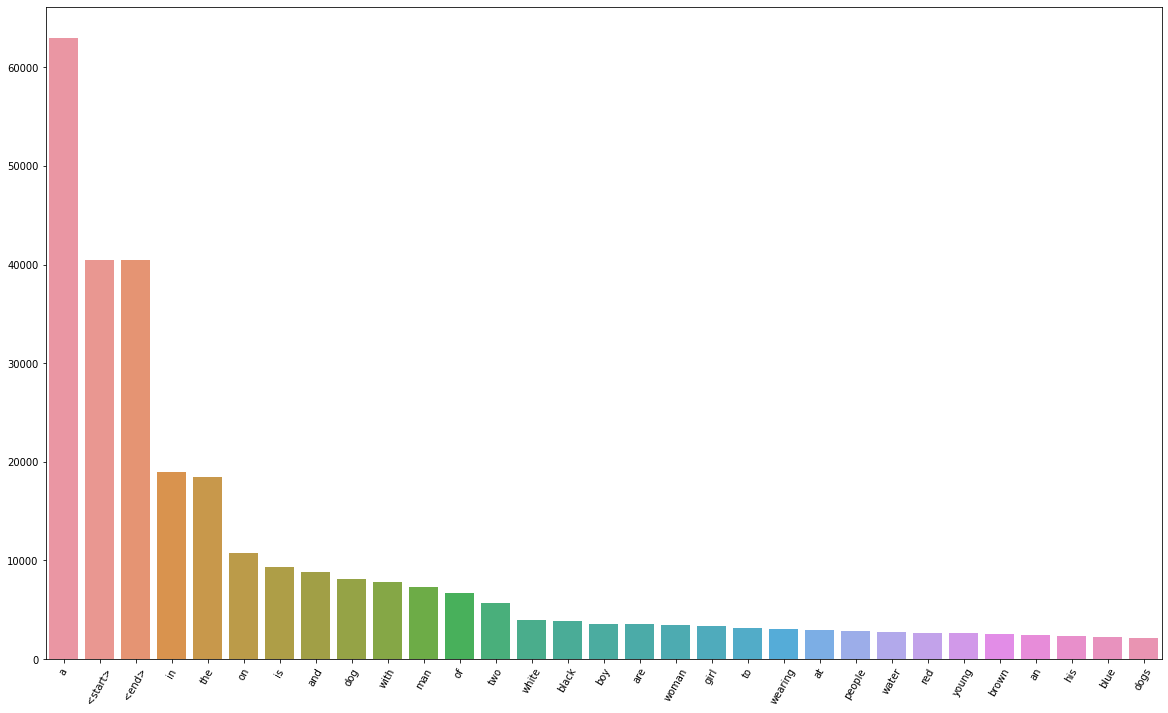

In [14]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
get_k_top_words(tokenizer.word_counts, 30)
#your code here

In [15]:
def get_min_max_count(array_of_array):
  final_array = [ len(e) for e in array_of_array ]
  return min(final_array),max(final_array)
min_array, max_array = get_min_max_count(train_text_seqs)

In [16]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_text_seqs, padding='post', maxlen = max_array) #your code here

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [17]:
#write your code here to create the dataset consisting of image paths
image_path_ds = sorted(set(all_img_vector))

In [18]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img,image_path 

In [19]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
feat_dict = {}
image_path_data_set = tf.data.Dataset.from_tensor_slices(image_path_ds)
image_path_data_set = image_path_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)



In [20]:
image_path_data_set

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [21]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

87916544/87910968 [==============================] - 1s 0us/step


In [22]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_features_extract_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [23]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [24]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [25]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(path_name,capt): # your input variable goes here)
  image_tensor = feat_dict[path_name.decode('utf-8')] # write your code here to extract the features from the dictionary stored earlier
  return image_tensor, capt

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [26]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

batch = 32
buffer = 1000
def gen_dataset(images_data, captions_data):
    ds = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    ds = ds.shuffle(buffer)

    ds = ds.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [27]:
for image, path in tqdm(image_path_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_new, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feat_dict[path_of_feature] =  batch_new.numpy()

100%|██████████| 253/253 [00:55<00:00,  4.60it/s]


In [28]:
batch_new.shape[1]

2048

In [29]:
batch_new.shape[0]


64

In [30]:
features_shape = batch_new.shape[1]
attention_features_shape = batch_new.shape[0]


In [31]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [32]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [33]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test)#len(total test images) // BATCH_SIZE

### Encoder

In [34]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = layers.Dense(embed_dim) #build your Dense layer with relu activation
        self.dropout = layers.Dropout(0.5)

    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [35]:
encoder=Encoder(embedding_dim)

### Attention model

In [36]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units) #build your Dense layer
        self.W2 = layers.Dense(units) #build your Dense layer
        self.V = layers.Dense(1) #build your final Dense layer with unit 1
        self.units = units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [37]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units) #build your Dense layer
        self.d2 = layers.Dense(vocab_size) #build your Dense layer
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.dropout(self.embed(x)) 
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed,mask=mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [38]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [39]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [40]:
optimizer = keras.optimizers.Adam() #define the optimizer
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [41]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [42]:
checkpoint_path_ckpt = "/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [43]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [44]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predict, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predict)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [45]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predict, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predict)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

In [46]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        loss_in_batch, tot_loss = test_step(img_tensor, target)
        total_loss = total_loss + tot_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [47]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [04:09<58:08, 249.21s/it]

For epoch: 1, the train loss is 0.037, & test loss is 0.031
Time taken for 1 epoch 249.0156056880951 sec

Test loss has been reduced from 100.000 to 0.031


 13%|█▎        | 2/15 [06:03<36:46, 169.75s/it]

For epoch: 2, the train loss is 0.029, & test loss is 0.028
Time taken for 1 epoch 113.99421715736389 sec

Test loss has been reduced from 0.031 to 0.028


 20%|██        | 3/15 [07:57<28:54, 144.52s/it]

For epoch: 3, the train loss is 0.027, & test loss is 0.026
Time taken for 1 epoch 114.3411967754364 sec

Test loss has been reduced from 0.028 to 0.026


 27%|██▋       | 4/15 [09:52<24:19, 132.67s/it]

For epoch: 4, the train loss is 0.025, & test loss is 0.024
Time taken for 1 epoch 114.35275053977966 sec

Test loss has been reduced from 0.026 to 0.024


 33%|███▎      | 5/15 [11:46<20:58, 125.87s/it]

For epoch: 5, the train loss is 0.023, & test loss is 0.022
Time taken for 1 epoch 113.68612313270569 sec

Test loss has been reduced from 0.024 to 0.022


 40%|████      | 6/15 [13:40<18:18, 122.08s/it]

For epoch: 6, the train loss is 0.022, & test loss is 0.021
Time taken for 1 epoch 114.5537805557251 sec

Test loss has been reduced from 0.022 to 0.021


 47%|████▋     | 7/15 [15:34<15:53, 119.15s/it]

For epoch: 7, the train loss is 0.021, & test loss is 0.020
Time taken for 1 epoch 112.98211908340454 sec

Test loss has been reduced from 0.021 to 0.020


 53%|█████▎    | 8/15 [17:27<13:42, 117.47s/it]

For epoch: 8, the train loss is 0.019, & test loss is 0.019
Time taken for 1 epoch 113.70927715301514 sec

Test loss has been reduced from 0.020 to 0.019


 60%|██████    | 9/15 [19:22<11:39, 116.59s/it]

For epoch: 9, the train loss is 0.018, & test loss is 0.018
Time taken for 1 epoch 114.49523544311523 sec

Test loss has been reduced from 0.019 to 0.018


 67%|██████▋   | 10/15 [21:16<09:38, 115.74s/it]

For epoch: 10, the train loss is 0.018, & test loss is 0.017
Time taken for 1 epoch 113.6773669719696 sec

Test loss has been reduced from 0.018 to 0.017


 73%|███████▎  | 11/15 [23:11<07:42, 115.53s/it]

For epoch: 11, the train loss is 0.017, & test loss is 0.016
Time taken for 1 epoch 114.89581680297852 sec

Test loss has been reduced from 0.017 to 0.016


 80%|████████  | 12/15 [25:05<05:45, 115.11s/it]

For epoch: 12, the train loss is 0.016, & test loss is 0.016
Time taken for 1 epoch 114.01216292381287 sec

Test loss has been reduced from 0.016 to 0.016


 87%|████████▋ | 13/15 [26:59<03:49, 114.80s/it]

For epoch: 13, the train loss is 0.015, & test loss is 0.015
Time taken for 1 epoch 113.92305326461792 sec

Test loss has been reduced from 0.016 to 0.015


 93%|█████████▎| 14/15 [28:53<01:54, 114.47s/it]

For epoch: 14, the train loss is 0.015, & test loss is 0.014
Time taken for 1 epoch 113.56687521934509 sec

Test loss has been reduced from 0.015 to 0.014


100%|██████████| 15/15 [30:47<00:00, 123.18s/it]

For epoch: 15, the train loss is 0.014, & test loss is 0.014
Time taken for 1 epoch 114.11969709396362 sec

Test loss has been reduced from 0.014 to 0.014


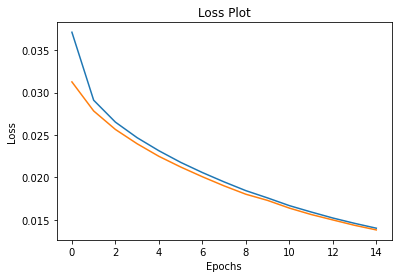

In [48]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [49]:
def evaluate(image):
    max_length = max_array
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value

        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list
        

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [55]:
def beam_evaluate(image, beam_index = 4):
    max_length=max_array
    start = [tokenizer.word_index['<start>']]
    res = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in res:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        res = temp
        res = sorted(res, reverse=False, key=lambda l: l[1])
        res = res[-beam_index:]
        
        
        predicted_id = res[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = res[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(res), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption


In [50]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [51]:
from nltk.translate.bleu_score import sentence_bleu

In [52]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

4890
BELU score: 100.0
Real Caption: a man rollerblading at a skate park
Prediction Caption: a man rollerblading at a skate park


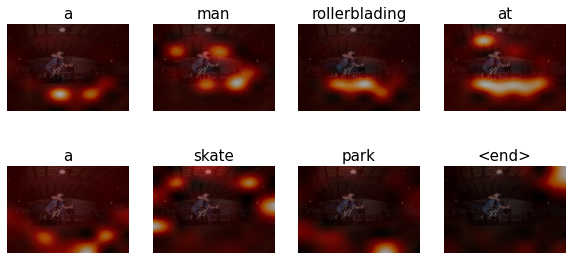

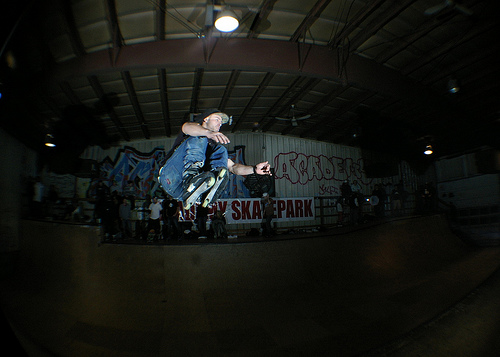

In [54]:
rid = np.random.randint(0, len(path_test))
print(rid)
test_image = path_test[rid]
#test_image = './Images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)